In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import Circle, ConnectionPatch
import numpy as np
import time
from collections import deque, defaultdict
import math
from networkx.drawing.nx_agraph import graphviz_layout

In [75]:
Graph = nx.nx_agraph.read_dot('./Dataset/JazzNetwork.dot/JazzNetwork.dot')
edge_list =[]
for e in Graph.edges():
    u,v = e
    edge_list.append((u,v))

node_list = []
for i in Graph.nodes():
    node_list.append(i)
    
print(len(edge_list))
print(len(node_list))

2742
198


In [71]:
def spring_embedder(G, positions, K, epsilon, delta, c_rep = 1, c_spring = 2, l = 1):
    
    def repulsive_force(distance, diff):
        return c_rep * diff / (distance**2)
    
    def spring_force(distance, diff):
        return c_spring * np.log(distance / l) * diff
    
    if positions is None:
        positions = {v: np.array([np.random.uniform(0, 1), np.random.uniform(0, 1)]) for v in G.nodes()}
    
    for iteration in range(K):
        displacement = {v: np.zeros(2) for v in G.nodes()}
        
        # Calculate repulsive forces
        for u in G.nodes():
            for v in G.nodes():
                if u != v:
                    diff = positions[u] - positions[v]
                    distance = np.linalg.norm(diff)
                    if distance > 0:
                        disp = repulsive_force(distance, diff)
                        displacement[u] += disp
        
        # Calculate attractive forces
        for u, v in G.edges():
            diff = positions[u] - positions[v]
            distance = np.linalg.norm(diff)
            if distance > 0:
                disp = spring_force(distance, diff)
                displacement[u] -= disp
                displacement[v] += disp
        
        # Update positions
        for v in positions:
            length = np.linalg.norm(displacement[v])
            if length > 0:
                # displacement vector is normalized
                positions[v] += delta * displacement[v] / length
                positions[v] = np.clip(positions[v], 0, 1)  # Keep within the bounds [0,1]x[0,1]
        
        # Check if maximum displacement is less than epsilon, if so, break
        max_displacement = max(np.linalg.norm(disp) for disp in displacement.values())
        if max_displacement < epsilon:
            break
    
    return positions

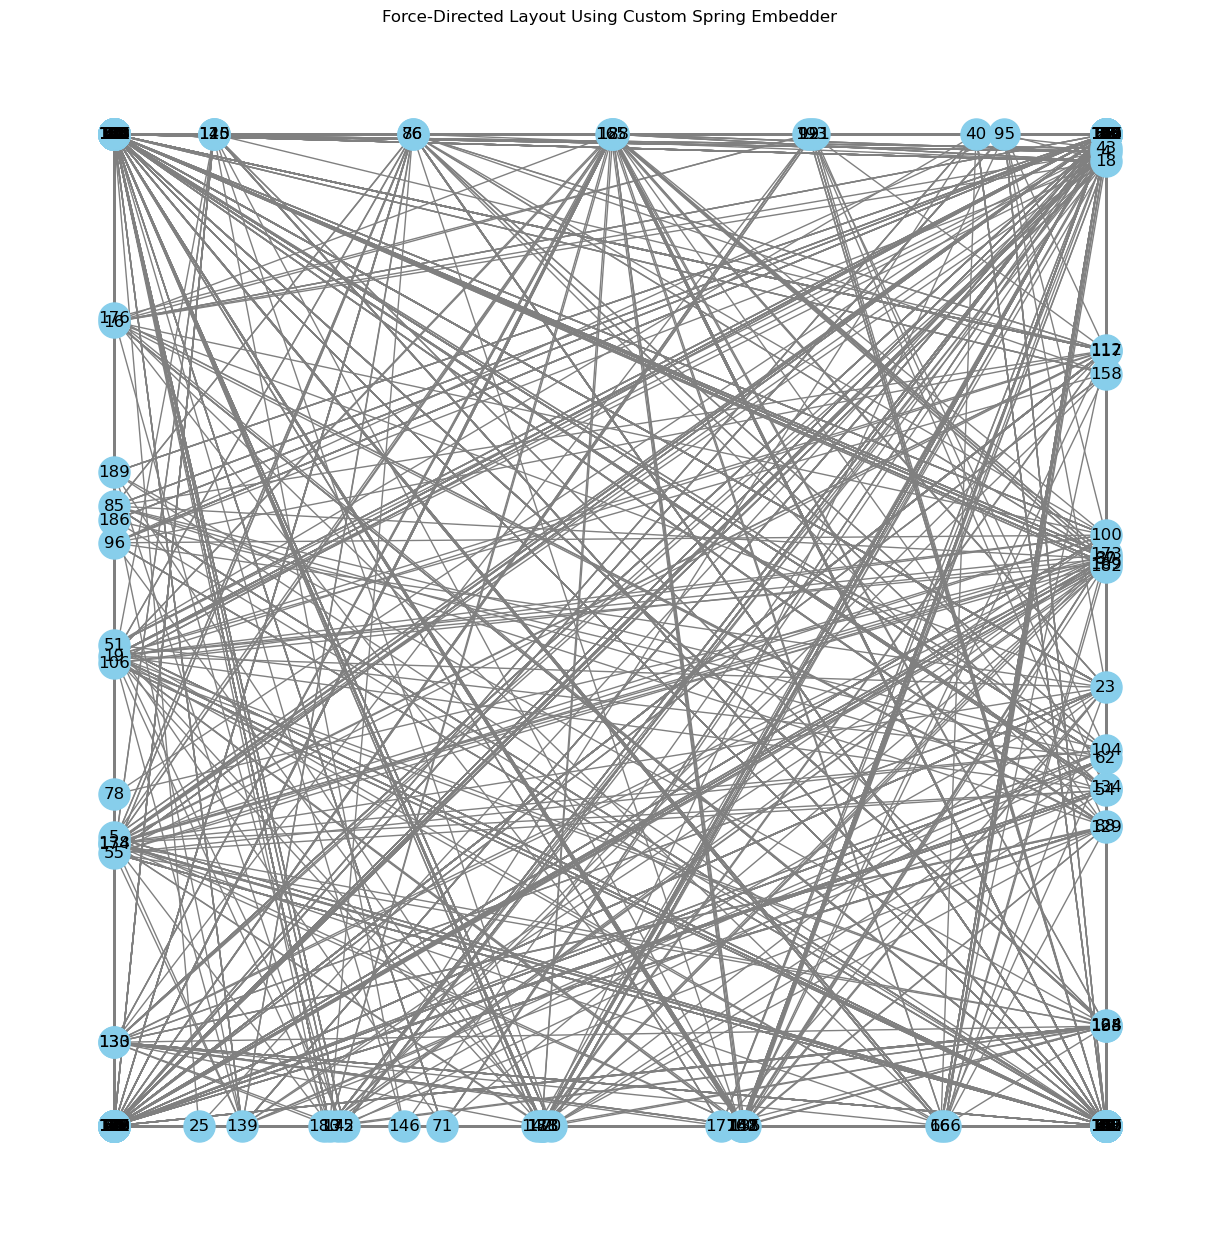

In [72]:
position = spring_embedder(G=Graph, positions= None, K=100 , epsilon=1e-4, delta=0.1, c_rep = 1, c_spring = 2, l = 1)
plt.figure(figsize=(12, 12))
nx.draw(Graph, position, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title('Force-Directed Layout Using Custom Spring Embedder')
plt.show()

In [85]:
def fruchterman_reingold(G, positions, K, epsilon, delta, area, c=1):
    k = c * np.sqrt(area / len(G.nodes()))  # Ideal edge length
    
    def repulsive_force(distance, diff):
        return (k**2 / distance) * diff
    
    def attractive_force(distance, diff):
        return (distance**2 / k) * diff
    
    if positions is None:
        positions = {v: np.array([np.random.uniform(0, 1), np.random.uniform(0, 1)]) for v in G.nodes()}
    
    for iteration in range(K):
        displacement = {v: np.zeros(2) for v in G.nodes()}
        
        # Calculate repulsive forces
        for u in G.nodes():
            for v in G.nodes():
                diff = positions[u] - positions[v]
                distance = np.linalg.norm(diff)
                if distance > 0:
                    disp = repulsive_force(distance, diff)
                    displacement[u] += disp
        
        # Calculate attractive forces
        for u,v in G.edges():
            diff = positions[u] - positions[v]
            distance = np.linalg.norm(diff)
            if distance > 0:
                disp = attractive_force(distance, diff)
                displacement[u] -= disp
                displacement[v] += disp
        
        # Update positions
        for v in positions:
            length = np.linalg.norm(displacement[v])
            if length > 0:
                # displacement vector is normalized
                positions[v] += delta * displacement[v] / length 
        
        max_displacement = max(np.linalg.norm(disp) for disp in displacement.values())
        
        if max_displacement < epsilon:
            break
    
    return positions


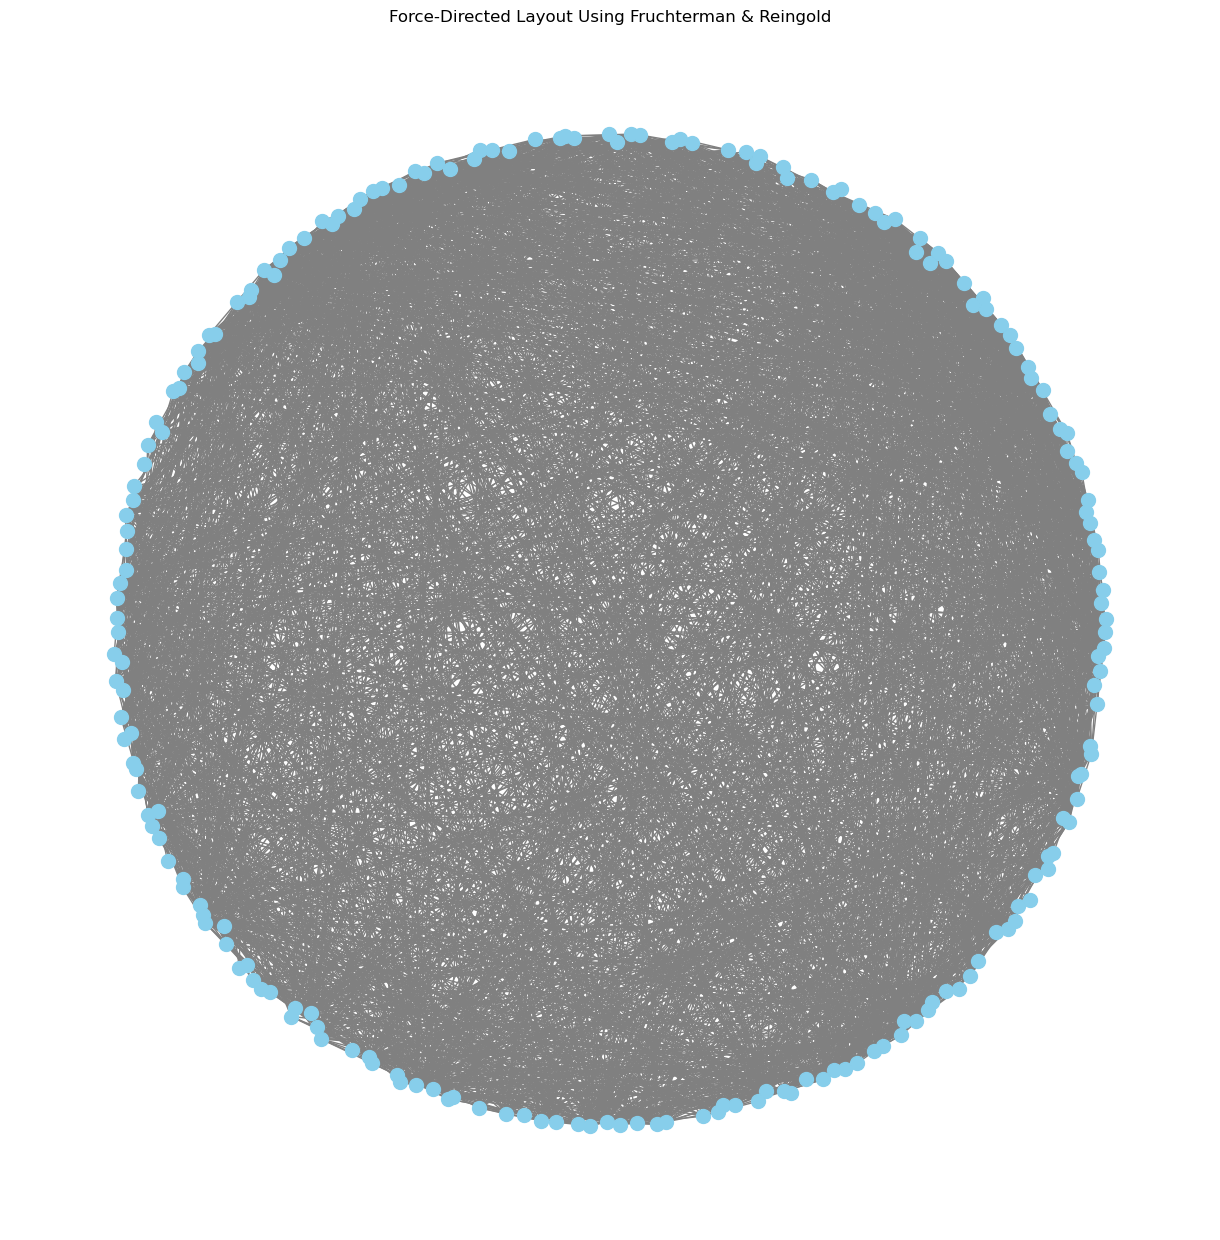

it took 27.121431589126587


In [97]:
t1 = time.time()
position = fruchterman_reingold(G=Graph, positions=None, K=100, epsilon=1e-4, delta=0.2, area=240*240, c=2)

plt.figure(figsize=(12, 12))
nx.draw(Graph, position, node_color='skyblue', node_size=100, edge_color='gray')
plt.title('Force-Directed Layout Using Fruchterman & Reingold')
plt.show()
t2 = time.time()
print(f'it took {t2-t1}')

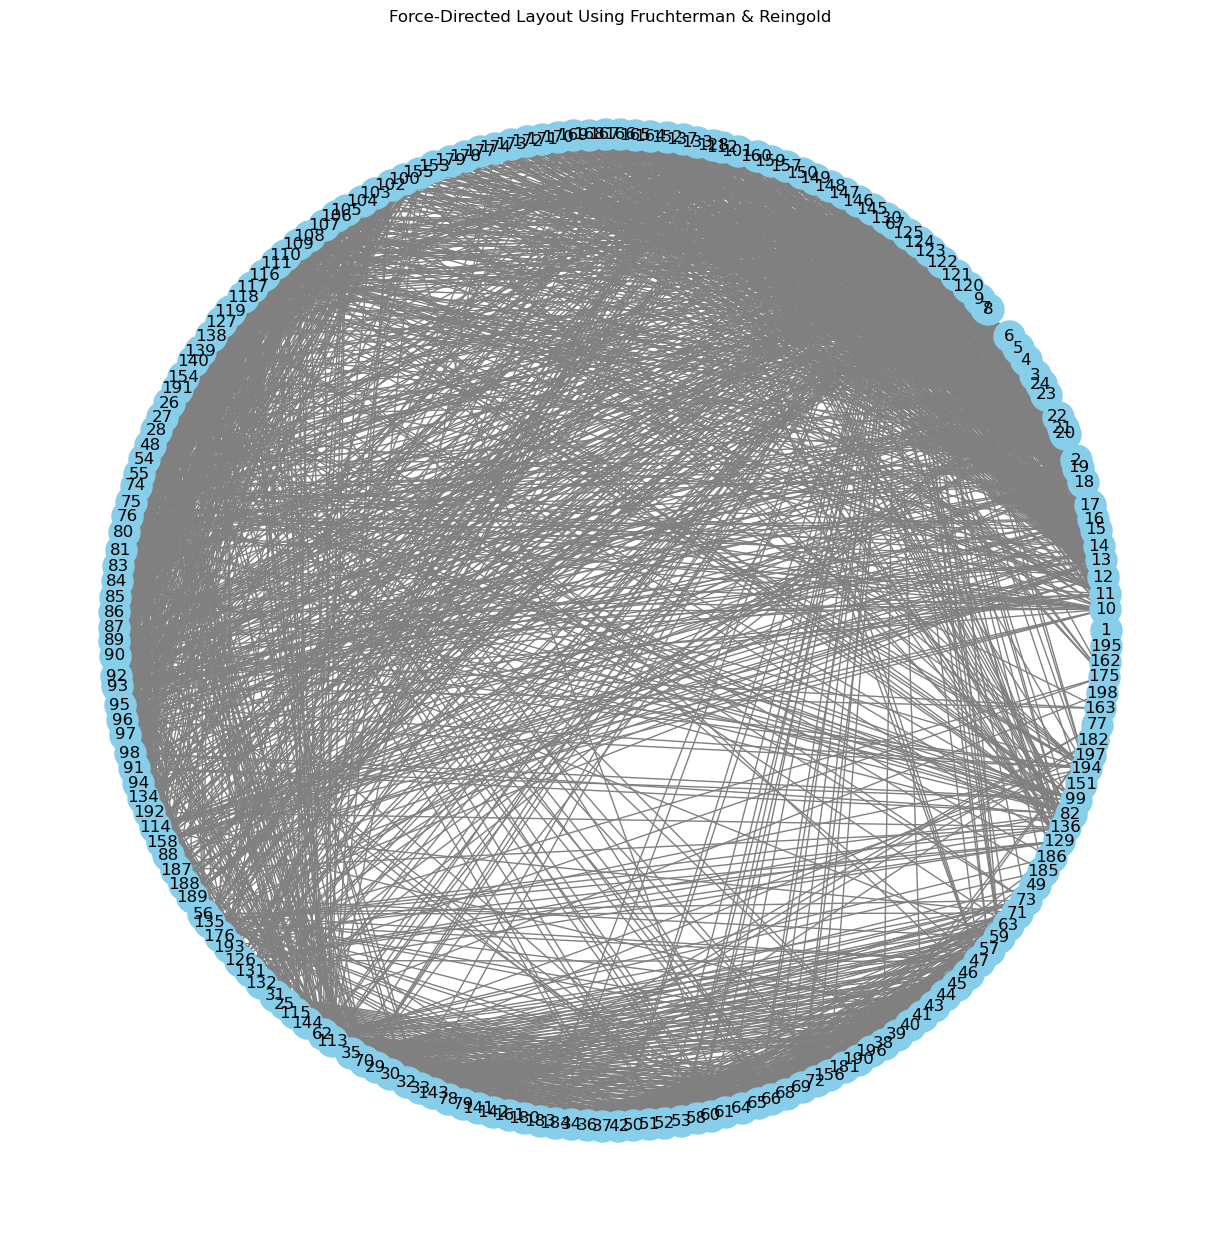

In [81]:
def initialize_positions_circle(G, radius=10):
    positions = {}
    num_nodes = G.number_of_nodes()
    angle = 2 * np.pi / num_nodes
    for i, node in enumerate(G.nodes()):
        x = radius * np.cos(i * angle)
        y = radius * np.sin(i * angle)
        positions[node] = np.array([x, y])
    return positions

initial_positions = initialize_positions_circle(Graph)
position = fruchterman_reingold(G=Graph, positions=initial_positions, K=100, epsilon=1e-4, delta=0.2, area=200*200, c=4)

# position = fruchterman_reingold(G=Graph, positions=None, K=100, epsilon=1e-4, delta=0.2, area=140*140, c=3)
plt.figure(figsize=(12, 12))
nx.draw(Graph, position, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
plt.title('Force-Directed Layout Using Fruchterman & Reingold')
plt.show()

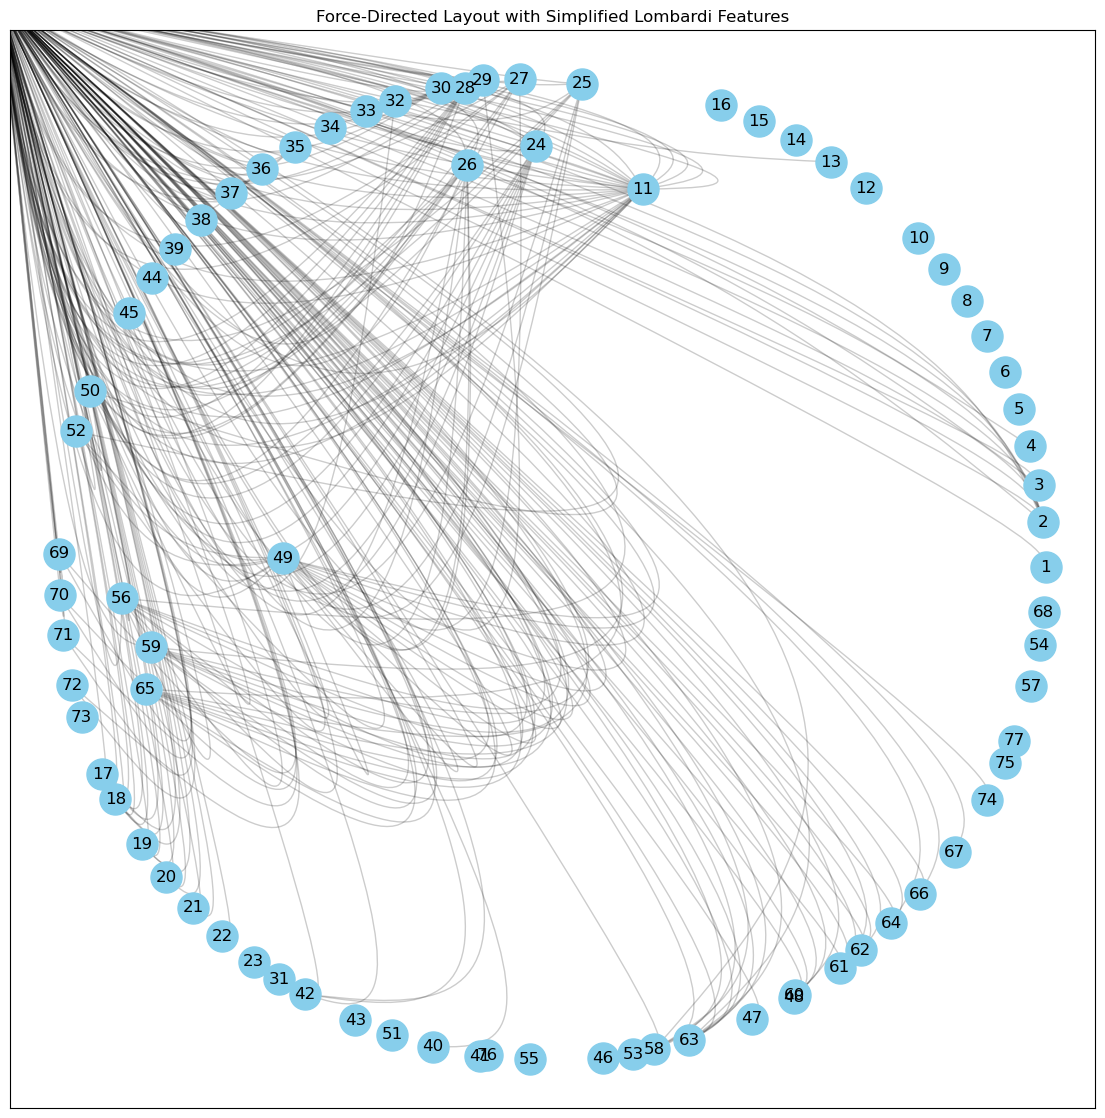

In [58]:
def draw_curved_edges(G, positions, ax, curvature):
    # Draw edges with consistent curvature
    for (u, v) in G.edges():
        start_pos = positions[u]
        end_pos = positions[v]
        midpoint = (start_pos + end_pos) / 2
        tangent = end_pos - start_pos
        normal = np.array([-tangent[1], tangent[0]])
        control_point = midpoint + curvature * normal / np.linalg.norm(normal)
        control_points = [start_pos, control_point, end_pos]
        codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4]
        path = Path(control_points, codes)
        patch = patches.PathPatch(path, facecolor='none', edgecolor='black', lw=1, alpha=0.2)  # Reduced alpha for transparency
        ax.add_patch(patch)

fig, ax = plt.subplots(figsize=(14, 14))
nx.draw_networkx_nodes(Graph, position, node_color='skyblue', node_size=500)
draw_curved_edges(Graph, position, ax, curvature=0.1)  # Adjust curvature as needed
nx.draw_networkx_labels(Graph, position)
plt.title('Force-Directed Layout with Simplified Lombardi Features')
plt.axis('equal')  # Set equal scaling by changing axis limits
plt.show()


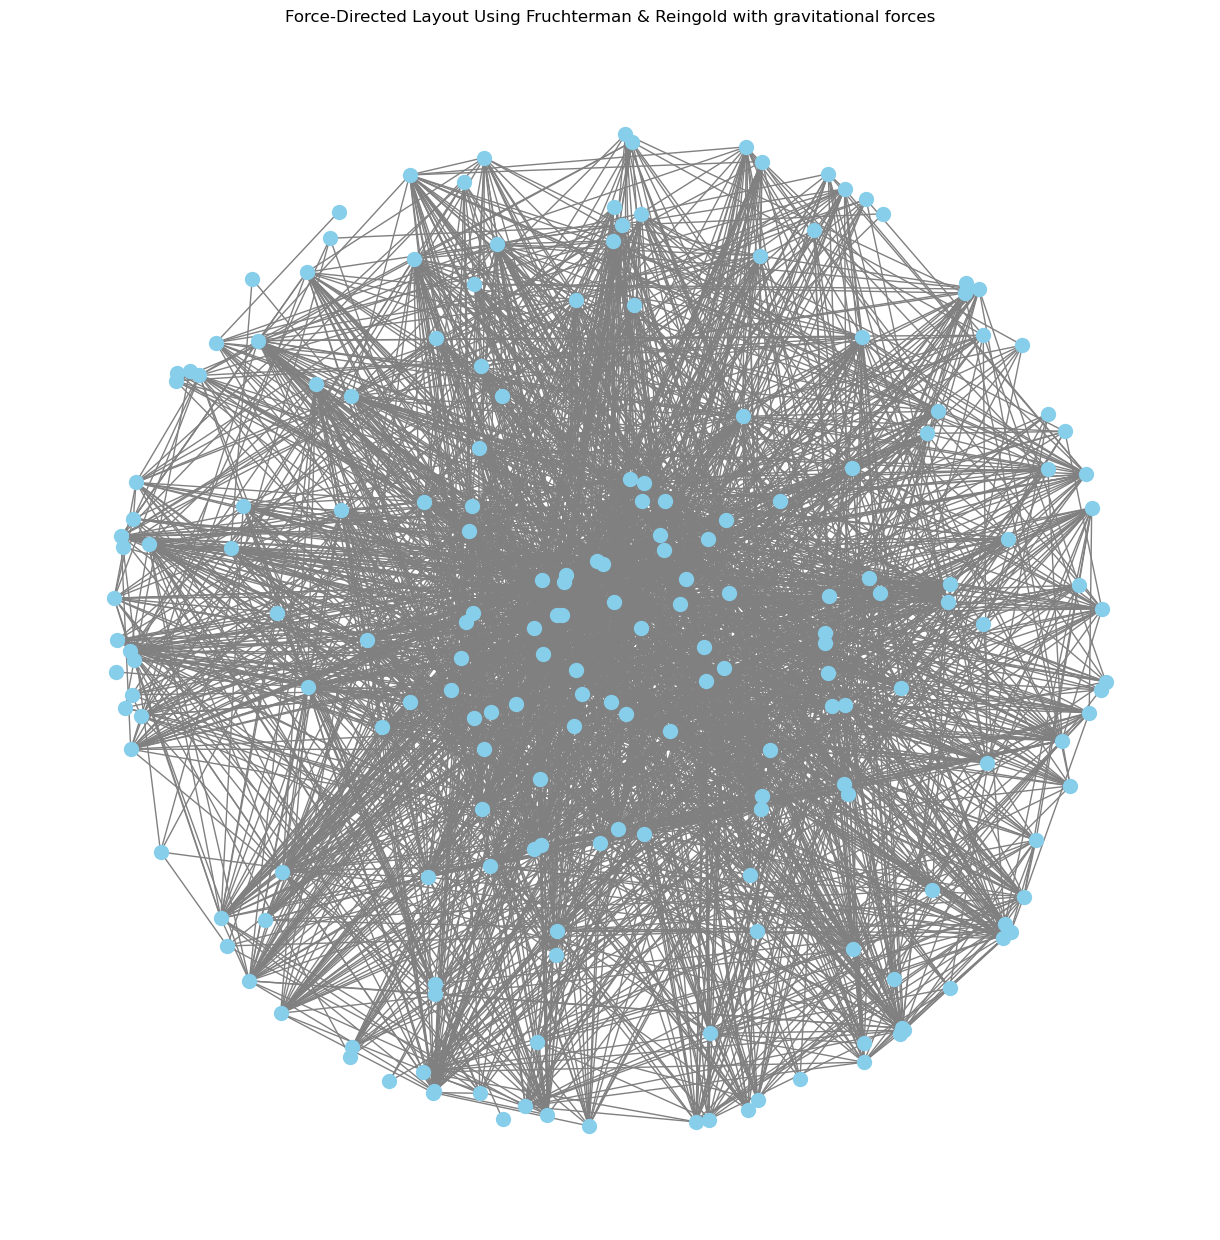

In [117]:
Graph = nx.nx_agraph.read_dot('./Dataset/JazzNetwork.dot/JazzNetwork.dot')
def fruchterman_reingold_update(G, positions, K, epsilon, delta, area, c=1, c_grav=0.1):
    k = c * np.sqrt(area / len(G.nodes()))  # Ideal edge length
    num_nodes = len(G.nodes())
    
    def repulsive_force(distance, diff):
        return (k**2 / distance) * diff
    
    # Modify the attractive force function to include inertia
    def attractive_force(distance, diff, mass):
        return (distance**2 / k) * diff / mass
    
    # Inertia function based on node degree
    def inertia(node):
        return 1 + G.degree(node) / 2
    
    # Define the barycenter of the graph
    def calculate_barycenter(positions):
        barycenter = np.sum(list(positions.values()), axis=0) / num_nodes
        return barycenter
    
    # Gravitational force towards the barycenter
    def gravitational_force(node_mass, node_position, barycenter):
        return c_grav * node_mass * (barycenter - node_position)
    
    if positions is None:
        positions = {v: np.array([np.random.uniform(0, 1), np.random.uniform(0, 1)]) for v in G.nodes()}

    barycenter = calculate_barycenter(positions)
    
    for iteration in range(K):
        displacement = {v: np.zeros(2) for v in G.nodes()}
        
        # Calculate repulsive forces
        for u in G.nodes():
            for v in G.nodes():
                diff = positions[u] - positions[v]
                distance = np.linalg.norm(diff)
                if distance > 0:
                    disp = repulsive_force(distance, diff)
                    displacement[u] += disp

        
        # Calculate attractive forces with inertia
        for u, v in G.edges():
            diff = positions[u] - positions[v]
            distance = np.linalg.norm(diff)
            if distance > 0:
                mass = inertia(v)  # Calculate the inertia (mass) of node v
                disp = attractive_force(distance, diff, mass)
                displacement[u] -= disp
                displacement[v] += disp / inertia(u)  # Apply inertia for node u as well
                
        # Apply gravitational force
        for v in positions:
            node_mass = inertia(v)
            grav_force = gravitational_force(node_mass, positions[v], barycenter)
            displacement[v] += grav_force
        
        # Update positions
        for v in positions:
            length = np.linalg.norm(displacement[v])
            if length > 0:
                # displacement vector is normalized
                positions[v] += delta * displacement[v] / length 
        
        barycenter = calculate_barycenter(positions)
        
        max_displacement = max(np.linalg.norm(disp) for disp in displacement.values())
        
        if max_displacement < epsilon:
            break
    
    return positions

# Use the modified function
position = fruchterman_reingold_update(G=Graph, positions=None, K=150, epsilon=1e-4, delta=0.1, area=40*40, c=1, c_grav=0.1)

plt.figure(figsize=(12, 12))
nx.draw(Graph, position, node_color='skyblue', node_size=100, edge_color='gray')
plt.title('Force-Directed Layout Using Fruchterman & Reingold with gravitational forces')
plt.show()